In [3]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# The Quest

## 4.1 EDA and Data Preprocessing

Zvolili sme si Age Detection Dataset (3 classes: old, middle, young) a s ním budeme aj pracovať

### EDA

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
import math
import os

In [5]:
data = pd.read_csv('data/faces/train.csv')

print(data.head())

          ID   Class
0    377.jpg  MIDDLE
1  17814.jpg   YOUNG
2  21283.jpg  MIDDLE
3  16496.jpg   YOUNG
4   4487.jpg  MIDDLE


In [6]:
data.info()
print(data['Class'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19906 entries, 0 to 19905
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      19906 non-null  object
 1   Class   19906 non-null  object
dtypes: object(2)
memory usage: 311.2+ KB
Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64


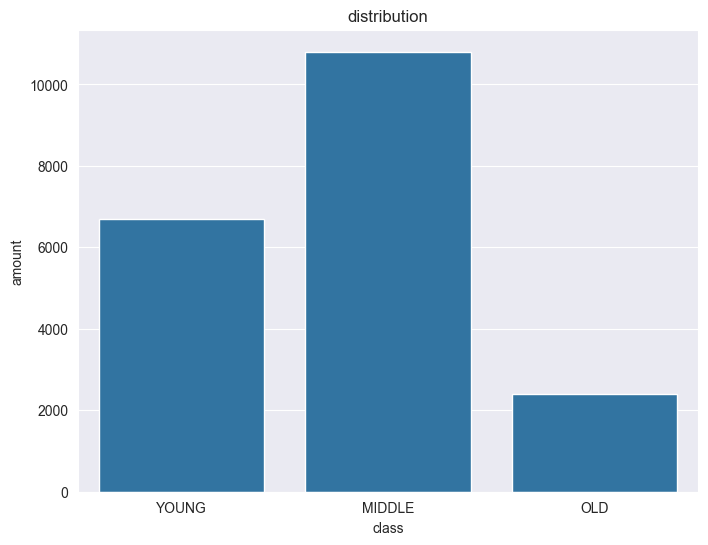

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Class', order=['YOUNG', 'MIDDLE', 'OLD'])
plt.title('distribution')
plt.xlabel('class')
plt.ylabel('amount')
plt.show()

#### môžeme si všimnúť, že dataset je mierne nevyvážený

In [8]:
percentages = data['Class'].value_counts(normalize=True) * 100
print(percentages)

Class
MIDDLE    54.275093
YOUNG     33.688335
OLD       12.036572
Name: proportion, dtype: float64


In [9]:
images_path = "data/faces/Train"
missing_files = []
for image_id in data['ID']:
    if not os.path.exists(os.path.join(images_path, image_id)):
        missing_files.append(image_id)


print(f"Missing files: {len(missing_files)}")

Missing files: 0


In [10]:
duplicate_rows = data[data.duplicated()]

duplicate_ids = data[data['ID'].duplicated()]

duplicate_row_count = duplicate_rows.shape[0]
duplicate_id_count = duplicate_ids.shape[0]

duplicate_row_count, duplicate_id_count

(0, 0)

Zistili sme, že nám žiadne obrázky nechýbajú a dáta neobsahujú ani duplicitné hodnoty. 

### Data Preprocessing

In [11]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

data['ID'] = data['ID'].str.replace('.jpg', '').astype(int)

data['Class'] = label_encoder.fit_transform(data['Class'])

class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
data.info()
data.head(), class_mapping

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19906 entries, 0 to 19905
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      19906 non-null  int32
 1   Class   19906 non-null  int32
dtypes: int32(2)
memory usage: 155.6 KB


(      ID  Class
 0    377      0
 1  17814      2
 2  21283      0
 3  16496      2
 4   4487      0,
 {'MIDDLE': 0, 'OLD': 1, 'YOUNG': 2})

#### Zmenili sme všetky dátové typy na numerické dátové typy - *encoding* a to nasledovne, ID - sme iba odstránili .jpg (aby to sa na to nepozeralo ako na objekt),Class - sme zakódovali nasledovne - 0 - MIDDLE; 1 - OLD; 2 - YOUNG  

#### Nasledne spojime data z obrazkov s datami z .csv suboru , aby sme pracovali s jednym datasetom 

In [12]:
from PIL import Image
import numpy as np

images_path = "data/faces/Train"
data['Image'] = None

for idx, row in data.iterrows():
    image_path = os.path.join(images_path, f"{row['ID']}.jpg")
    if os.path.exists(image_path):
        with Image.open(image_path) as img:
            img = img.resize((64, 64))
            img_array = np.array(img)
            data.at[idx, 'Image'] = img_array
    else:
        print(f"Obrázok {row['ID']} neexistuje!")

data.head()

,ID,Class,Image
0,377,0,"[[[51, 47, 48], [49, 46, 47], [44, 42, 43], [4..."
1,17814,2,"[[[47, 30, 36], [47, 30, 36], [47, 30, 36], [4..."
2,21283,0,"[[[44, 40, 39], [44, 39, 38], [46, 40, 40], [5..."
3,16496,2,"[[[21, 21, 21], [21, 21, 21], [21, 21, 21], [2..."
4,4487,0,"[[[28, 27, 33], [24, 23, 29], [23, 21, 27], [1..."


#### Všetky obrázky sme normalizovali

In [13]:
X = np.array(data['Image'].tolist())
y = data['Class'].values

print(X)

# Normalization
X = X / 255.0

print(X)
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


[[[[ 51  47  48]
   [ 49  46  47]
   [ 44  42  43]
   ...
   [  3  10   2]
   [  7  15   6]
   [  6  14   5]]

  [[ 51  48  49]
   [ 48  46  47]
   [ 44  42  43]
   ...
   [  9  15   8]
   [ 13  19  11]
   [ 12  18  10]]

  [[ 57  55  56]
   [ 54  52  53]
   [ 50  48  49]
   ...
   [ 18  23  16]
   [ 20  25  18]
   [ 19  24  17]]

  ...

  [[124 152 140]
   [117 142 132]
   [ 92 114 105]
   ...
   [101 116 123]
   [121 136 143]
   [135 150 157]]

  [[120 148 136]
   [113 139 128]
   [ 89 111 102]
   ...
   [104 120 127]
   [124 139 146]
   [138 153 160]]

  [[121 149 137]
   [114 140 129]
   [ 89 111 101]
   ...
   [103 118 125]
   [122 137 144]
   [136 151 158]]]


 [[[ 47  30  36]
   [ 47  30  36]
   [ 47  30  36]
   ...
   [ 35  22  14]
   [ 35  24  15]
   [ 35  25  15]]

  [[ 46  29  33]
   [ 46  29  33]
   [ 45  29  33]
   ...
   [ 35  22  13]
   [ 37  24  15]
   [ 37  25  16]]

  [[ 43  27  30]
   [ 43  27  30]
   [ 42  27  30]
   ...
   [ 37  23  14]
   [ 37  23  14]
   [ 36  23

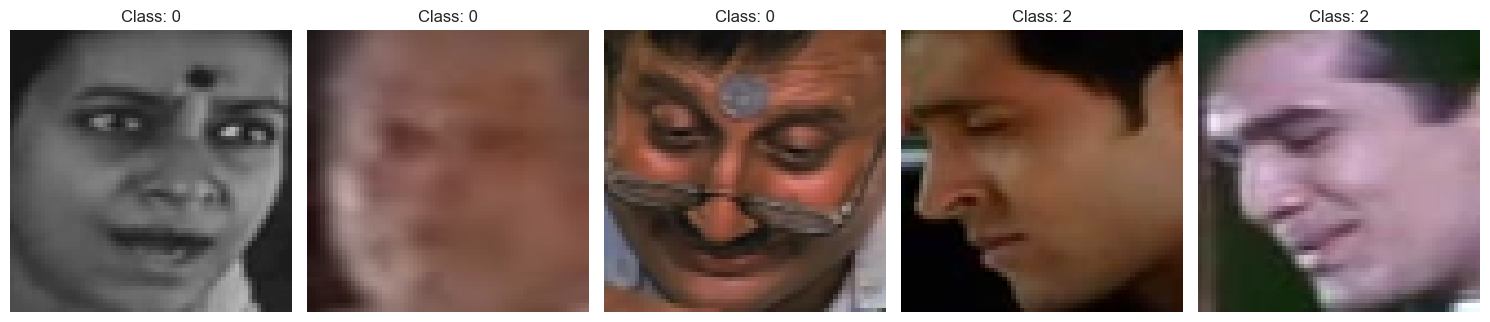

In [14]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i])
    ax.set_title(f"Class: {y_train[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

#### Pre klasifikáciu obrázkového datasetu sme sa rozhodli použiť Convolutional Neural Network (CNN), pretože táto architektúra je špeciálne navrhnutá na spracovanie obrazových dát a má preukázateľnú účinnosť v podobných úlohách.

## 4.2 Modeling and Evaluation

In [15]:
# pip install tensorflow==2.12.0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Create the CNN model
def create_age_classification_model(input_shape):
    model = Sequential([
        # First convolutional layer
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Second convolutional layer
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Flatten the 2D feature maps
        Flatten(),
                # Fully connected layers
        Dense(128, activation='relu'),
        Dropout(0.5),  # Prevent overfitting
        
        # Output layer for 3 age groups
        Dense(3, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam', 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    
    return model

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Prepare data augmentation to improve model generalization
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()  # No augmentation for validation data

# Create the model
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = create_age_classification_model(input_shape)

# Train the model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
    epochs=20
) 

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

Epoch 1/20
399/399 [==============================] - 17s 42ms/step - loss: 0.9337 - accuracy: 0.5572 - val_loss: 0.8578 - val_accuracy: 0.6349
Epoch 2/20
399/399 [==============================] - 19s 48ms/step - loss: 0.8738 - accuracy: 0.6035 - val_loss: 0.7912 - val_accuracy: 0.6581
Epoch 3/20
399/399 [==============================] - 26s 65ms/step - loss: 0.8531 - accuracy: 0.6108 - val_loss: 0.7679 - val_accuracy: 0.6619
Epoch 4/20
399/399 [==============================] - 21s 53ms/step - loss: 0.8299 - accuracy: 0.6212 - val_loss: 0.7445 - val_accuracy: 0.6785
Epoch 5/20
399/399 [==============================] - 17s 44ms/step - loss: 0.8253 - accuracy: 0.6280 - val_loss: 0.7197 - val_accuracy: 0.6832
Epoch 6/20
399/399 [==============================] - 17s 44ms/step - loss: 0.8097 - accuracy: 0.6380 - val_loss: 0.7251 - val_accuracy: 0.6832
Epoch 7/20
399/399 [==============================] - 17s 43ms/step - loss: 0.7938 - accuracy: 0.6450 - val_loss: 0.6953 - val_accuracy:

#### Výsledky modelovania

#### Trénovali sme model na 20 epochách, kde konečná presnosť dosiahla 71.19 %
#### Model bol trénovaný aj na 10 epochách, kde konečná presnosť na testovacích dátach dosiahla 69.66 %

#### viac sme už netestovali, pretože by nastal overfitting

125/125 [==============================] - 1s 10ms/step


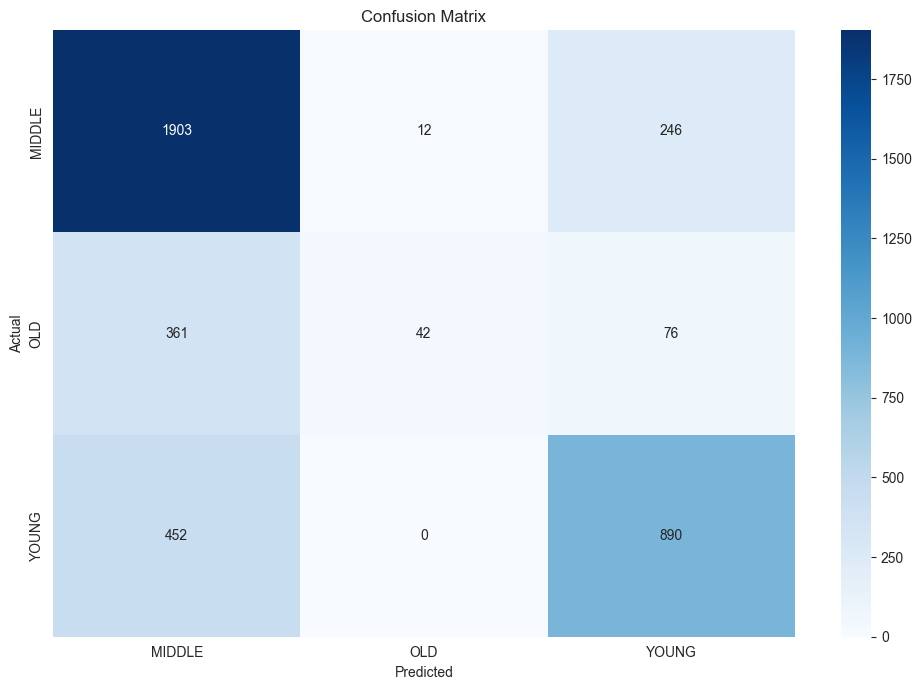

In [19]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['MIDDLE', 'OLD', 'YOUNG'], 
            yticklabels=['MIDDLE', 'OLD', 'YOUNG'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

#### Confusion Matrix ukázal, že trieda OLD bola najčastejšie nesprávne klasifikovaná, čo pravdepodobne súvisí s jej malou reprezentáciou v dátach.

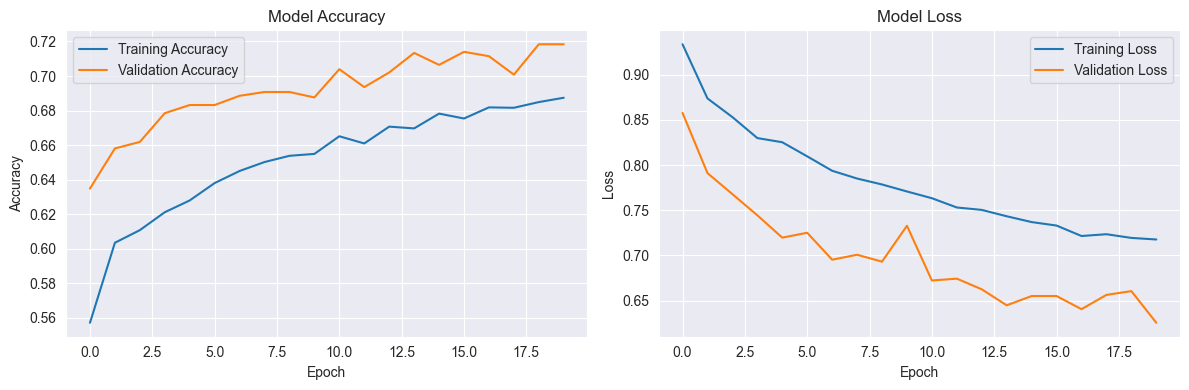

In [20]:
# Learning curves
plt.figure(figsize=(12, 4))

# Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#### Neidentifikovali sme žiadne výrazné rozdiely medzi tréningovou a validačnou presnosťou/stratou, čiže sa model učí vzory bez pretrénovania

In [18]:
print(classification_report(y_test, y_pred_classes, target_names=['MIDDLE', 'OLD', 'YOUNG']))

              precision    recall  f1-score   support

      MIDDLE       0.70      0.88      0.78      2161
         OLD       0.78      0.09      0.16       479
       YOUNG       0.73      0.66      0.70      1342

    accuracy                           0.71      3982
   macro avg       0.74      0.54      0.54      3982
weighted avg       0.72      0.71      0.68      3982



### CNN model sa ukázal ako optimálny pre klasifikáciu obrázkov aj pre tento prípad.

50/50